### BloomTech Data Science


---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**


In [58]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [59]:
import pandas as pd

In [60]:
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [61]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [62]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

In [63]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [64]:
pd.set_option('display.max_columns', 500)

# I. Wrangle Data

In [65]:
def wrangle(filepath):

  df = pd.read_csv(filepath,
                   parse_dates=['issue_d'],
                   index_col='issue_d').sort_index()

  # Set issue date to index

  # subset data to 36-month loans
  mask = df['term'].str.strip() == '36 months'
  df = df[mask]
  df.drop(columns='term', inplace=True)

  # Turn `'int_rate'` col into float
  df['int_rate'] = df['int_rate'].str.strip(' %').astype(float)

    
  # Consolidate and OHE loan purpose (`'title'`)

  

  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  for key in keywords:
    df[key] = (df['title'].fillna('').str.lower()
                .str.contains(key, regex=True)
                .astype(int))

  

  columns_to_keep = keywords + ['annual_inc','funded_amnt','int_rate','fico_range_high']
  df = df[columns_to_keep]
  
  # Rename columns
  df.rename(columns={'annual_inc': 'annual_income',
                    'business': 'purpose_business',
                    'car|vacation|medical|moving': 'purpose_major_purchase',
                    'consolidation|credit': 'purpose_consolidation',
                    'fico_range_high': 'credit_score',
                    'funded_amnt': 'loan_amount',
                    'home': 'purpose_home_purchase',
                    'int_rate': 'interest_rate'}, inplace=True)
  return df

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [66]:
df.shape

(102996, 8)

In [67]:
df.head()

,purpose_business,purpose_consolidation,purpose_home_purchase,purpose_major_purchase,annual_income,loan_amount,interest_rate,credit_score
issue_d,,,,,,,,
2007-07-01,0,0,0,0,20000.0,3500.0,10.28,684.0
2007-07-01,0,0,0,0,95000.0,5000.0,7.43,774.0
2007-07-01,0,0,0,0,150000.0,5000.0,7.43,779.0
2007-07-01,0,0,0,0,200000.0,3000.0,10.28,679.0
2007-08-01,0,0,0,0,61800.0,4000.0,7.75,749.0


In [68]:
df.head()

,purpose_business,purpose_consolidation,purpose_home_purchase,purpose_major_purchase,annual_income,loan_amount,interest_rate,credit_score
issue_d,,,,,,,,
2007-07-01,0,0,0,0,20000.0,3500.0,10.28,684.0
2007-07-01,0,0,0,0,95000.0,5000.0,7.43,774.0
2007-07-01,0,0,0,0,150000.0,5000.0,7.43,779.0
2007-07-01,0,0,0,0,200000.0,3000.0,10.28,679.0
2007-08-01,0,0,0,0,61800.0,4000.0,7.75,749.0


# II. Split Data

In [69]:
# Split our data in feature matrix and target vector
target = 'interest_rate'
X = df.drop(columns=target)
y = df[target]

In [70]:
int(len(X)*.1)

10299

In [71]:
# Split data into training, validation, test sets
# Because this is datetime data, we'll do a cutoff
# sort_index is the key here! take tail as test data! 

# numpy array slicing syntax
X_train, y_train = X[:-20_000], y[:-20_000]
X_val, y_val = X[-20_000:-10_000], y[-20_000:-10_000]
X_test, y_test = X[-10_000:], y[-10_000:]

# III. Establish Baseline

In [72]:
print('Mean interest rate:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean interest rate: 11.559685527013349
Baseline MAE: 2.8988644656907225


# IV. Build Model

In [73]:
# not using any pipelines

model_lr = LinearRegression()
model_r = Ridge()
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

In [74]:
model_lr.fit(X_train, y_train);
model_r.fit(X_train, y_train);
model_rf.fit(X_train, y_train);
model_xgb.fit(X_train, y_train);

[18:49:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# V. Check Metrics

In [75]:
def check_metrics(model):
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE: 2.3998605913358455
Validation MAE: 2.6447773070690257
Validation R^2: 0.22254825417422197


Training MAE: 2.399861638504497
Validation MAE: 2.644770560435676
Validation R^2: 0.22255361069312118


Training MAE: 1.1495022990410637
Validation MAE: 2.7699335974071904
Validation R^2: 0.1408914858381678


Training MAE: 2.272805379672627
Validation MAE: 2.549306864238739
Validation R^2: 0.26929027112924564




# VI. Communicate Results

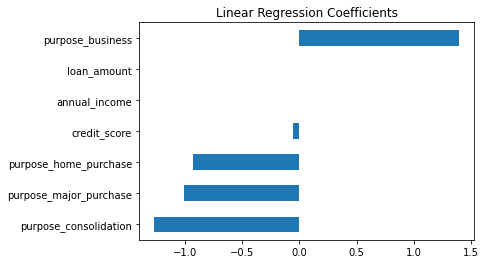

In [76]:
coefficients = model_lr.coef_
coef = pd.DataFrame(data=coefficients, index=X_train.columns,columns=['coefficients'])
coef['coefficients'].sort_values().plot(kind='barh');
plt.title('Linear Regression Coefficients')
plt.show()

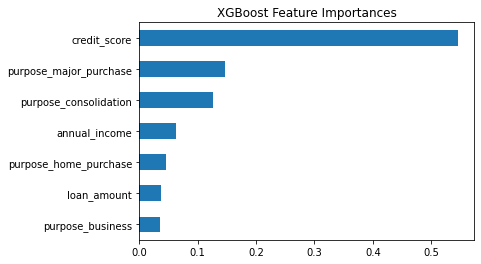

In [77]:
importances = model_xgb.feature_importances_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh');
plt.title('XGBoost Feature Importances')
plt.show()

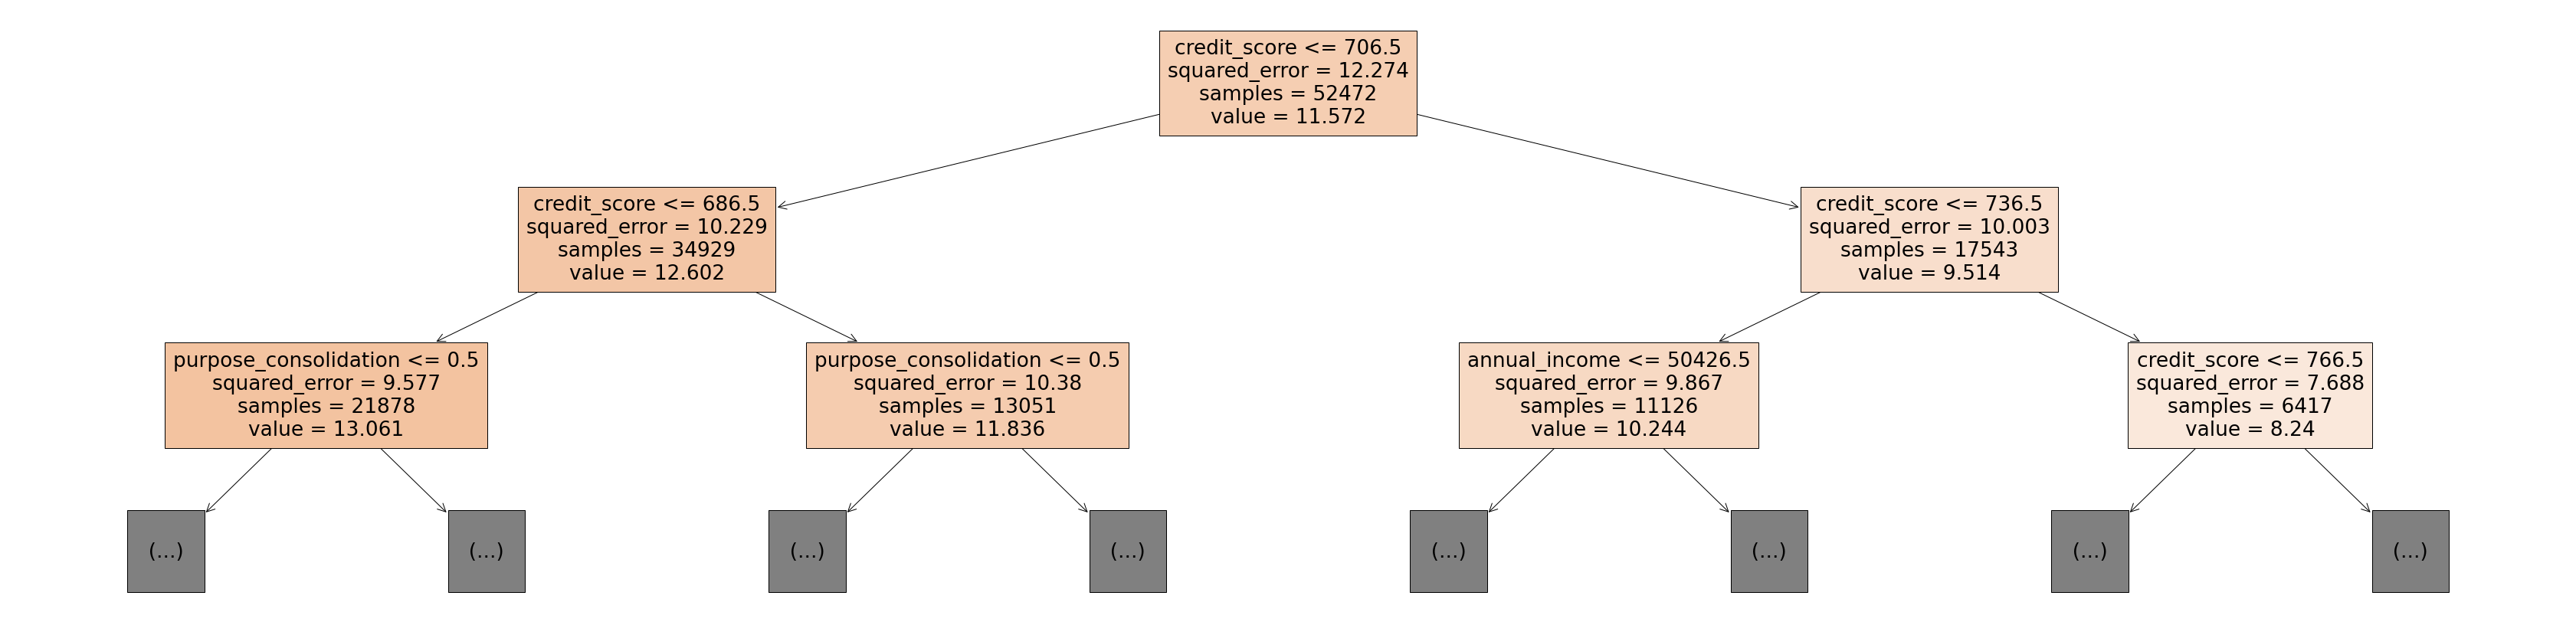

In [78]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,15))

plot_tree(
     model_rf.estimators_[0],
     max_depth=2,
     feature_names=X_train.columns,
     filled=True
);

## Partial Dependence Plots

One Feature

In [79]:
# select one feature
samp_feat = 'annual_income'

isolate = pdp_isolate(
    model_xgb,
    dataset = X_val,
    model_features=X_val.columns,
    feature=samp_feat
    )

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5072d6bcd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f507f032c90>})

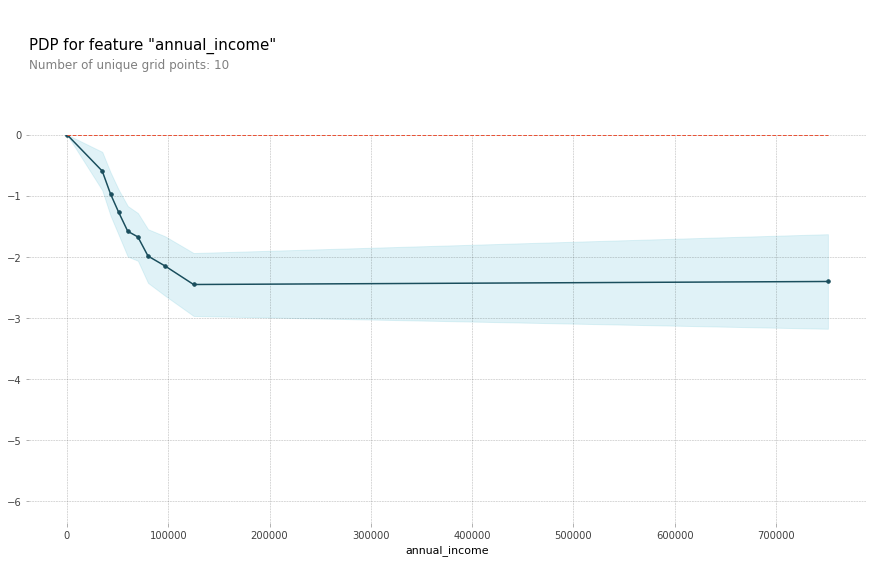

In [80]:
# create an instance of PDP Isolate.
pdp_plot(isolate, feature_name=samp_feat)

In [81]:
pd.qcut(X['annual_income'], q=10).value_counts()

(48000.0, 55000.0]       11317
(63000.0, 72000.0]       10683
(32000.0, 40000.0]       10622
(99900.0, 125000.0]      10608
(-0.001, 32000.0]        10514
(82500.0, 99900.0]       10262
(40000.0, 48000.0]       10009
(125000.0, 9300000.0]     9991
(55000.0, 63000.0]        9512
(72000.0, 82500.0]        9478
Name: annual_income, dtype: int64

In [82]:
isolate.percentile_info

array(['(0.0)', '(11.11)', '(22.22)', '(33.33)', '(44.44)', '(55.56)',
       '(66.67)', '(77.78)', '(88.89)', '(100.0)'], dtype=object)

In [83]:
isolate.pdp

array([13.071857 , 12.475682 , 12.099575 , 11.801365 , 11.489561 ,
       11.397461 , 11.084156 , 10.9199915, 10.618689 , 10.668109 ],
      dtype=float32)

Two features

In [84]:
# select two features
samp_feats = ['annual_income', 'credit_score']

interact = pdp_interact(
    model_xgb,
    dataset = X_val,
    model_features=X_val.columns,
    features=samp_feats
    )

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f507ae3d0d0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5072d81810>})

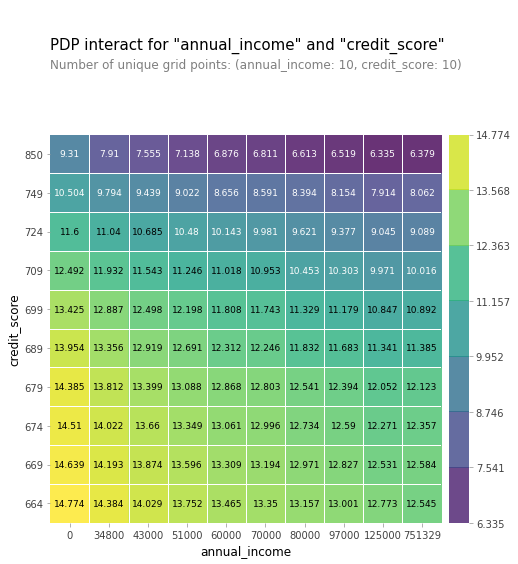

In [85]:
# create an instance of PDP Interact.
pdp_interact_plot(interact, plot_type='grid', feature_names=samp_feats)

## Shapley Plots

In [87]:
#select one sample/observation (row)
samp_row = X_val.tail(1)

In [88]:
samp_row

,purpose_business,purpose_consolidation,purpose_home_purchase,purpose_major_purchase,annual_income,loan_amount,credit_score
issue_d,,,,,,,
2017-08-01,0,1,0,0,38000.0,7000.0,739.0


In [92]:
# Shapley Force Plot
# This may not work well in local notebooks
# you may need to install ipywidgets

# shapley plots don't work well with pipelines! So  we need to give it our completely transformed model :+1:
explainer = shap.TreeExplainer(model_xgb)
shap_vals = explainer.shap_values(samp_row)

#initialization of java script
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_vals,
    features=samp_row
)

